In [3]:
import pandas as pd 
import time
import math
import random

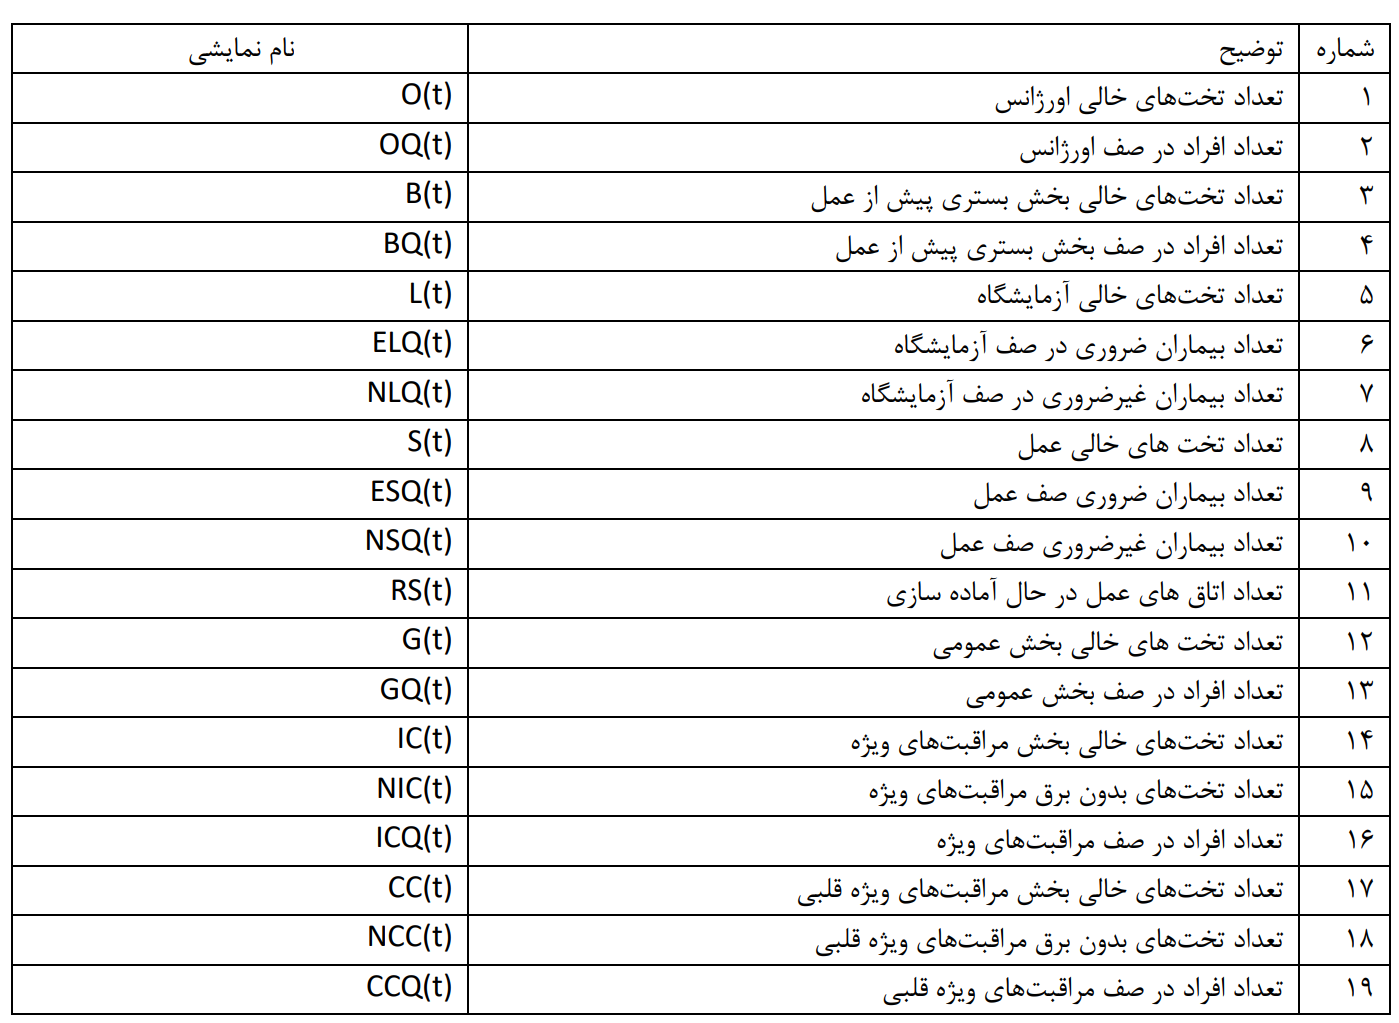

In [4]:
stats = {'fully_u':0,'eff_u':0,'eff_b':0,'eff_l':0,'eff_s':0,'eff_g':0,'eff_icu':0,'eff_ccu':0}


In [5]:
# generating random numbers

def exponential(lambd):
    r = random.random()
    return -(1 / lambd) * math.log(r)


def uniform(a, b):
    r = random.random()
    return a + (b - a) * r

def Triangular(max,mean,min):
    r = random.random()
    F_c = (max - min) / (mean - min)
    if r <= F_c:
        return min + math.sqrt(r * (mean - min) * (max - min))
    else:
        return mean - math.sqrt((1 - r) * (mean - min) * (mean - max))

def Normal(m,v):
    u1 = random.random()
    u2 = random.random()
    z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2 * math.pi * u2)
    norm = z0 * math.sqrt(v) + m

    return norm

def uniform_dis(a,b):
    r = random.random()

    value = math.floor(a + r* (b - a + 1))

    return value

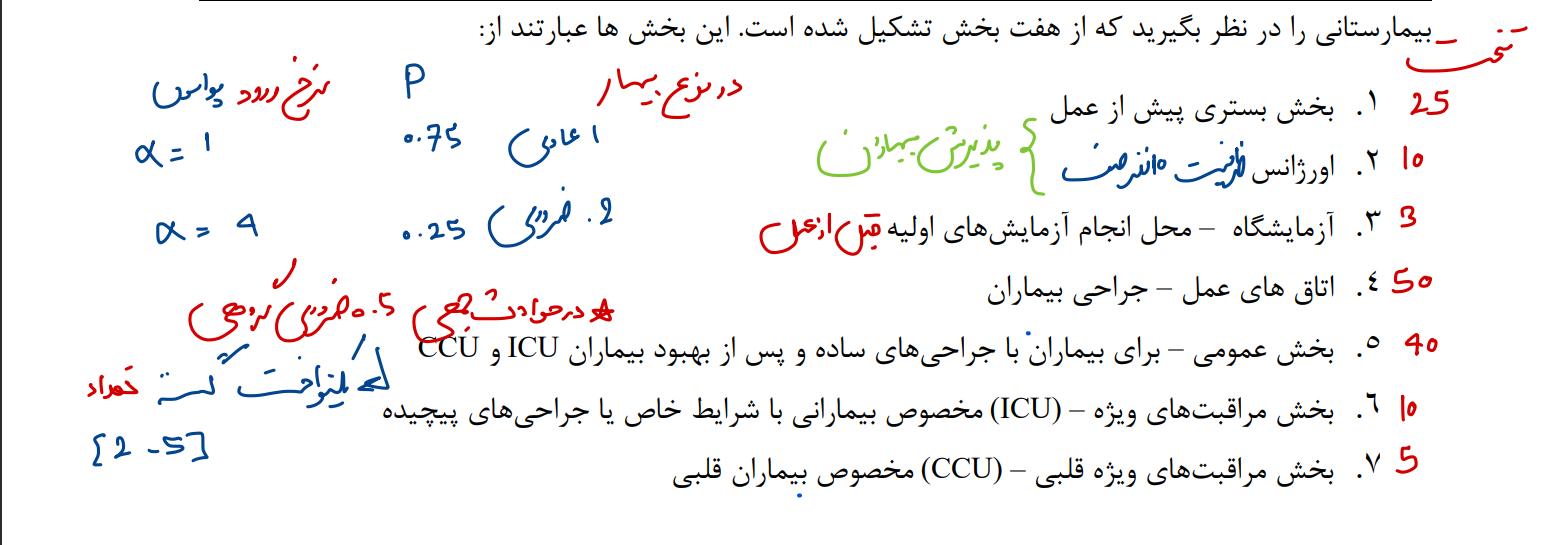

In [95]:
import pandas as pd 
import time
import math
import random

# generating random numbers

def exponential(lambd):
    r = random.random()
    return -(1 / lambd) * math.log(r)


def uniform(a, b):
    r = random.random()
    return a + (b - a) * r

def Triangular(max,mean,min):
    r = random.random()
    F_c = (max - min) / (mean - min)
    if r <= F_c:
        return min + math.sqrt(r * (mean - min) * (max - min))
    else:
        return mean - math.sqrt((1 - r) * (mean - min) * (mean - max))

def Normal(m,v):
    u1 = random.random()
    u2 = random.random()
    z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2 * math.pi * u2)
    norm = z0 * math.sqrt(v) + m

    return norm

def uniform_dis(a,b):
    r = random.random()

    value = math.floor(a + r* (b - a + 1))

    return value

def update_cumulative_stats():
    initial_tresh = 1000
    if(T < initial_tresh):
        return
    # Update efficiency of beds
    stats['eff_u'] = ((last_T - initial_tresh)*stats['eff_u'] + (T - last_T)*state_vars['U'])/(T-initial_tresh)
    stats['eff_b'] = ((last_T - initial_tresh)*stats['eff_b'] + (T - last_T)*state_vars['B'])/(T-initial_tresh)
    stats['eff_l'] = ((last_T - initial_tresh)*stats['eff_l'] + (T - last_T)*state_vars['L'])/(T-initial_tresh)
    stats['eff_s'] = ((last_T - initial_tresh)*stats['eff_s'] + (T - last_T)*state_vars['S'])/(T-initial_tresh)
    stats['eff_g'] = ((last_T - initial_tresh)*stats['eff_g'] + (T - last_T)*state_vars['G'])/(T-initial_tresh)
    stats['eff_icu'] = ((last_T - initial_tresh)*stats['eff_icu'] + (T - last_T)*state_vars['IC'])/(T-initial_tresh)
    stats['eff_ccu'] = ((last_T - initial_tresh)*stats['eff_ccu'] + (T - last_T)*state_vars['CC'])/(T-initial_tresh)
    # Update queue statistics
    for i in Q_lists:
        Q_lists[i]['avg'] = ((last_T - initial_tresh)* Q_lists[i]['avg'] + (T - last_T)*len( Q_lists[i]['que']))/(T-initial_tresh)
        Q_lists[i]['max'] = max( Q_lists[i]['max'],len( Q_lists[i]['que']))


state_vars = {'U':10,'UQ':0,'B':25,'BQ':0,'L':3,'ELQ':0,'NLQ':0,'S':50,'ESQ':0,'NSQ':0,'RS':0,'G':40,'GQ':0,'IC':10,'NIC':0,'ICQ':0,'CC':5,'NCC':0,'CCQ':0}
type_of_events = ['ES','NS','LS','LE','SS','SE','RSE','GE','IC','NIC','CCE','NCCE','NS','NE']
Q_lists = { 'UQ': {'que': [], 'avg': 0, 'max': 0}, 'BQ': {'que': [], 'avg': 0, 'max': 0},
            'ELQ': {'que': [], 'avg': 0, 'max': 0}, 'NLQ': {'que': [], 'avg': 0, 'max': 0},
            'ESQ': {'que': [], 'avg': 0, 'max': 0}, 'NSQ': {'que': [], 'avg': 0, 'max': 0}, 
            'GQ': {'que': [], 'avg': 0, 'max': 0}, 'ICQ': {'que': [], 'avg': 0, 'max': 0}, 
            'CCQ': {'que': [], 'avg': 0, 'max': 0} }
patient_dict = {} # List of Patient objects that have entered the system
stats = {'fully_u':0,'eff_u':0,'eff_b':0,'eff_l':0,'eff_s':0,'eff_g':0,'eff_icu':0,'eff_ccu':0}
patient_pos = ['U','UQ','B','BQ','L','LQ','S','SQ','G','GQ','ICU','ICUQ','CCU','CCUQ']
T = 0 # Current event time
last_T = 0 # Last event time
number_of_patient = 0  # Total number of patients entered the system
FEL = [] # List of Event objects, sorted by time, 
class Patient():
    def __init__(self,arrival_time,type,number):
        # Initialize patient properties
        self.arrival = arrival_time
        self.type = type # 'E': Emergency , 'N': normal
        self.number = number # Patient number
        self.departure = 0
        self.sur_entrance_time = 0
        self.sur_counter = 0 # Surgery count
        self.s_arrival_time = -1 # Arrival time of current section
        self.surgery_type = None # 's' simple, 'm' medium, 'c' complex
        self.current_pos = None # Current position
        # Waiting times in queues
        self.uqt = 0 # Waiting in emergency queue
        self.bqt = 0 # Waiting in bed queue
        self.lqt = 0 # Waiting in laboratory queue
        self.sqt = 0 # Waiting in surgery queue
        self.gqt = 0 # Waiting in ward(G) que
        self.icuqt = 0 # Waiting in ICU que
        self.ccuqt = 0 # Waitng in CCU que
        # Service times
        self.ut = 0 # Duration in emergency
        self.lt = 0 # Duration in laboratory
        self.st = 0 # Duration of surgery
        self.gt = 0 # Duration in ward(G)
        self.icut = 0 # Duration in ICU
        self.ccut = 0 # Duraiont in CCU

    def get_values(self): 
        return { 'arrival_time': self.arrival, 'sur_entrance_time': self.sur_entrance_time, 'sur_counter': self.sur_counter,
                 'departure': self.departure, 's_arrival_time': self.s_arrival_time, 'surgery_type': self.surgery_type,
                 'current_pos': self.current_pos, 'uqt': self.uqt, 'bqt': self.bqt, 'lqt': self.lqt, 'sqt': self.sqt, 'gqt': self.gqt,
                 'icuqt': self.icuqt, 'ccuqt': self.ccuqt, 'ut': self.ut, 'lt': self.lt, 'st': self.st, 'gt': self.gt, 'icut': self.icut,
                 'ccut': self.ccut ,'type':self.type}
class Event():
    """
    Represents an event in the simulation.
    type: An element of ['ES','NS','LS','LE','SS','SE','RSE','GE','IC','NIC','CCE','NCCE','NS','NE']
    patient: Patient number associated with the event
    time: The time when the event occurs
    """
    def __init__(self,type,patient,time,FEL):
        self.type = type
        self.patient = patient
        self.time = time
        self.update_FEL(FEL)
    def update_FEL(self,FEL):
        # Insert event into Future Event List (FEL) sorted by time
        for i in range(len(FEL)):
            if(self.time < FEL[i].time):
                FEL.insert(i,self)
                return       
        FEL.append(self)           
def ES():
    # Check if it is a single or group entrance
    global number_of_patient,T,last_T
    rn = random.random() # Placeholder value, should be edited , random.random()
    if(rn < 0.995):
        # Single entrance
        if(state_vars['UQ'] < 10): # Check the emergency queue length
            # patient_number = len(patient_dict) + 1
            number_of_patient += 1
            patient_dict[number_of_patient] = Patient(T, 'E', number_of_patient) # Add new emergency patient
            if(state_vars['U'] > 0): # Check if there is an available emergency bed
                print('####')
                state_vars['U'] -= 1 # Update count of available emergency beds
                print([(i.type,i.time) for i in FEL])
                Event('LS', number_of_patient, T + 10, FEL) # Schedule lab start event
                print([(i.type,i.time) for i in FEL])
                patient_dict[number_of_patient].current_pos = 'U' # Update current position of patient
                patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of current position
            else: # No available emergency bed
                state_vars['UQ'] += 1 # Update length of emergency queue
                Q_lists['UQ']['que'].append(number_of_patient) # Add patient to emergency queue
                patient_dict[number_of_patient].current_pos = 'UQ' # Update current position of patient
                patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of current position
        else: # Emergency queue capacity is full
            stats['fully_u'] += 1 # Update fully_u statistic
    else:
        # Group entrance
        number = uniform_dis(2,5) # Generate random number
        if(number <= state_vars['U']):
            for i in range(number):
                number_of_patient += 1
                delay_time = random.random()/100
                patient_dict[number_of_patient] = Patient(T+delay_time ,'E', number_of_patient) # Add new emergency patients
                Event('LS', number_of_patient, T + delay_time+ 10, FEL) # Schedule lab start event
                patient_dict[number_of_patient].current_pos = 'U' # Update current position of the patient
                patient_dict[number_of_patient].s_arrival_time = T+delay_time # Update arrival time of the current position
            state_vars['U'] -= number # Update count of available emergency beds 
    # Generate next arrival

    interarrival_time = exponential(1/15) # Generate random number for next arrival time
    Event('ES', number_of_patient + 1, T + interarrival_time, FEL)
def NS():
    global number_of_patient,T,last_T
    number_of_patient += 1
    patient_dict[number_of_patient] = Patient(T, 'N', number_of_patient) # Add new normal patient
    if(state_vars['B'] > 0): # Check if there is an available bed in B
        state_vars['B'] -= 1 # Update count of available beds
        Event('LS', number_of_patient, T + 60, FEL) # Schedule lab start event
        patient_dict[number_of_patient].current_pos = 'B' # Update current position of the patient
        patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of the current position
    else:
        state_vars['BQ'] += 1 # Update length of B queue
        Q_lists['BQ']['que'].append(number_of_patient) # Add patient to B queue
        patient_dict[number_of_patient].current_pos = 'BQ' # Update current position of the patient
        patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of the current position
    
    rn3 = random.random()

    intervarrival_time = exponential(1/60) # Generate random number for next arrival time
    Event('NS', number_of_patient + 1, T + intervarrival_time, FEL) # Schedule next normal patient arrival
def LS(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    if(patient_dict[patient_number].type == 'E'): # Emergency patient!
        if(state_vars['L'] > 0): # Free lab available
            state_vars['L'] -= 1
            lab_duration = uniform(28,32) # Should be edited with actual duration
            Event('LE', patient_number, T + lab_duration, FEL)
            patient_dict[patient_number].current_pos = 'L'
            patient_dict[patient_number].s_arrival_time = T
        else: # Full lab, patient should wait in queue
            state_vars['ELQ'] += 1
            Q_lists['ELQ']['que'].append(patient_number)
            patient_dict[patient_number].current_pos = 'LQ'
            patient_dict[patient_number].s_arrival_time = T
    else: # Normal patient
        if(state_vars['L'] > 0): # Free lab available
            state_vars['L'] -= 1
            lab_duration = uniform(28,32) # Should be edited with actual duration
            Event('LE', patient_number, T + lab_duration, FEL)
            patient_dict[patient_number].current_pos = 'L'
            patient_dict[patient_number].s_arrival_time = T
        else: # Full lab, patient should wait in queue
            state_vars['NLQ'] += 1
            Q_lists['NLQ']['que'].append(patient_number)
            patient_dict[patient_number].current_pos = 'LQ'
            patient_dict[patient_number].s_arrival_time = T
def LE(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    # Handle forward events
    if(patient_dict[patient_number].type == 'E'): # Check if the patient is an emergency patient
        ss_arrival_time = Triangular(100,75,5) # Set surgery arrival time for emergency patient
        Event('SS',patient_number,T + ss_arrival_time,FEL)
        patient_dict[patient_number].current_pos = 'U' # Update current position to 'U'
        patient_dict[patient_number].lt = T - patient_dict[patient_number].s_arrival_time # Update the leave time
        patient_dict[patient_number].s_arrival_time = T # Update the arrival time
    elif(patient_dict[patient_number].type == 'N'):
        ss_arrival_time = 60*48 # Set surgery arrival time for normal patient
        Event('SS',patient_number,T + ss_arrival_time,FEL)
        patient_dict[patient_number].current_pos = 'B' # Update current position to 'B'
        patient_dict[patient_number].lt = T - patient_dict[patient_number].s_arrival_time # Update the leave time
        patient_dict[patient_number].s_arrival_time = T # Update the arrival time
    else:
        raise Exception('patient type is not E nor U!')
    # Handle backward events
    if(state_vars['ELQ'] > 0): # Check if there are emergency patients in the lab queue
        patient_number = Q_lists['ELQ']['que'].pop(0) # Get the first patient in the ELQ queue
        state_vars['ELQ'] -= 1 # Update the ELQ state variable
        lab_duration = uniform(28,32) # Set lab duration (should be edited)
        Event('LE',patient_number,T + lab_duration,FEL)
        patient_dict[patient_number].current_pos = 'L' # Update current position to 'L'
        patient_dict[patient_number].lqt = T - patient_dict[patient_number].s_arrival_time # Update the lab queue time
        patient_dict[patient_number].s_arrival_time = T # Update the arrival time
    elif(state_vars['NLQ']>0): # Check if there are normal patients in the lab queue
        patient_number = Q_lists['NLQ']['que'].pop(0) # Get the first patient in the NLQ queue
        state_vars['NLQ'] -= 1 # Update the NLQ state variable
        lab_duration = uniform(28,32) # Set lab duration (should be edited)
        Event('LE',patient_number,T + lab_duration,FEL)
        patient_dict[patient_number].current_pos = 'L' # Update current position to 'L'
        patient_dict[patient_number].lqt = T - patient_dict[patient_number].s_arrival_time # Update the lab queue time
        patient_dict[patient_number].s_arrival_time = T # Update the arrival time
    else:
        state_vars['L'] += 1
def SS(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    ra = random.random()  # Type of surgery
    if ra <= 0.5:
        sur_type = 's'
    elif 0.5 < ra <= 0.95:
        sur_type = 'm'
    else:
        sur_type = 'c' 
    patient_dict[patient_number].surgery_type = sur_type
    # Forward operations
    if state_vars['S'] > 0:
        state_vars['S'] -= 1
        if sur_type == 's':  # Simple surgery
            sur_duration = Normal(30.22 , 22.56)  # Duration of simple surgery
        elif sur_type == 'm':  # Medium surgery
            sur_duration = Normal(74.54 , 99.11)  # Duration of medium surgery
        else:  # Complex surgery
            sur_duration = Normal(242.03 , 4003.67) # Duration of complex surgery
        Event('SE', patient_number, T + sur_duration, FEL)
        patient_dict[patient_number].current_pos = 'S'
        patient_dict[patient_number].st += sur_duration
        patient_dict[patient_number].sur_counter += 1
        patient_dict[patient_number].sur_entrance_time = T
    else:  # No available surgery room
        if patient_dict[patient_number].type == 'E':  # Emergency patient
            state_vars['ESQ'] += 1
            Q_lists['ESQ']['que'].append(patient_number)
        else:  # Non-emergency patient
            state_vars['NSQ'] += 1
            Q_lists['NSQ']['que'].append(patient_number)
        patient_dict[patient_number].current_pos = 'QS'
        patient_dict[patient_number].s_arrival_time = T
    # Backward operations
    if patient_dict[patient_number].type == 'E':
        if state_vars['UQ'] > 0:
            state_vars['UQ'] -= 1
            patient_number = Q_lists['UQ']['que'].pop(0)
            Event('LS', patient_number, T + 10, FEL)
            patient_dict[patient_number].current_pos = 'U'
            patient_dict[patient_number].uqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
        else:
            state_vars['U'] += 1
    else:
        if state_vars['BQ'] > 0:
            state_vars['BQ'] -= 1
            patient_number = Q_lists['BQ']['que'].pop(0)
            Event('LS', patient_number, T + 60, FEL)
            patient_dict[patient_number].current_pos = 'B'
            patient_dict[patient_number].bqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
        else:
            state_vars['B'] += 1
def SE(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    sur_type = patient_dict[patient_number].surgery_type
    # Forward operations
    if sur_type == 's':
        if state_vars['G'] > 0:  # Available bed in ward
            state_vars['G'] -= 1
            recovery_duration = exponential(1/3000)  # Duration in ward
            Event('GE', patient_number, T + recovery_duration, FEL)
            patient_dict[patient_number].current_pos = 'G'
            patient_dict[patient_number].gt += recovery_duration
        else:  # No available bed, wait in GQ
            state_vars['GQ'] += 1
            Q_lists['GQ']['que'].append(patient_number)
            patient_dict[patient_number].current_pos = 'GQ'
            patient_dict[patient_number].s_arrival_time = T
    elif sur_type == 'm':
        re_ty = random.random()  # Type of recovery room
        if re_ty <= 0.7:
            recovery_room = 'ward'
        elif 0.7 < re_ty <= 0.9:
            recovery_room = 'CCU'
        else:
            recovery_room = 'ICU' 
        if recovery_room == 'ICU':
            if state_vars['IC'] > 0:  # Available ICU bed
                state_vars['IC'] -= 1
                recovery_duration = exponential(1/1500)  # Duration in ICU min
                Event('ICE', patient_number, T + recovery_duration, FEL)
                patient_dict[patient_number].current_pos = 'IC'
                patient_dict[patient_number].s_arrival_time = T
                patient_dict[patient_number].icut += recovery_duration
            else:  # No available ICU bed
                state_vars['ICQ'] += 1
                Q_lists['ICQ']['que'].append(patient_number)
                patient_dict[patient_number].current_pos = 'ICQ'
                patient_dict[patient_number].s_arrival_time = T
        elif recovery_room == 'CCU':  # Available CCU bed
            if state_vars['CC'] > 0:
                state_vars['CC'] -= 1
                recovery_duration = exponential(1/1500)  # Duration in CCU
                Event('CCE', patient_number, T + recovery_duration, FEL)
                patient_dict[patient_number].current_pos = 'CC'
                patient_dict[patient_number].s_arrival_time = T
                patient_dict[patient_number].ccut += recovery_duration
            else:  # No available CCU bed
                state_vars['CCQ'] += 1
                Q_lists['CCQ']['que'].append(patient_number)
                patient_dict[patient_number].current_pos = 'CCQ'
                patient_dict[patient_number].s_arrival_time = T
        else:
            if state_vars['G'] > 0:  # Available bed in ward
                state_vars['G'] -= 1
                recovery_duration = exponential(1/3000)  # Duration in ward
                Event('GE', patient_number, T + recovery_duration, FEL)
                patient_dict[patient_number].current_pos = 'G'
                patient_dict[patient_number].gt += recovery_duration
            else:  # No available bed, wait in GQ
                state_vars['GQ'] += 1
                Q_lists['GQ']['que'].append(patient_number)
                patient_dict[patient_number].current_pos = 'GQ'
                patient_dict[patient_number].s_arrival_time = T
    else:  # Complex surgery
        #is_dead = False  # Randomly generated
        de = random.random()
        if de <= 0.1:
            is_dead = True
        else:
            is_dead = False
        if not is_dead:
            retry_sur = random.random() # Check if retry surgery is required
            if retry_sur < .01:
                retry_sur = True
            else:
                retry_sur = False
            if not retry_sur:
                heart_sur = random.random()  # Check if operation is a heart surgery
                if heart_sur<.25:
                    heart_sur = True
                else:
                    heart_sur = False
                if not heart_sur:
                    if state_vars['IC'] > 0:  # Available ICU bed
                        state_vars['IC'] -= 1
                        recovery_duration = exponential(1/1500) # Duration in ICU
                        Event('ICE', patient_number, T + recovery_duration, FEL)
                        patient_dict[patient_number].current_pos = 'IC'
                        patient_dict[patient_number].s_arrival_time = T
                        patient_dict[patient_number].icut += recovery_duration
                    else:  # No available ICU bed
                        state_vars['ICQ'] += 1
                        Q_lists['ICQ']['que'].append(patient_number)
                        patient_dict[patient_number].current_pos = 'ICQ'
                        patient_dict[patient_number].s_arrival_time = T

                else:
                    if state_vars['CC'] > 0:  # Available CCU bed
                        state_vars['CC'] -= 1
                        recovery_duration = exponential(1/1500)  # Duration in CCU
                        Event('CCE', patient_number, T + recovery_duration, FEL)
                        patient_dict[patient_number].current_pos = 'CC'
                        patient_dict[patient_number].s_arrival_time = T
                        patient_dict[patient_number].ccut += recovery_duration
                    else:  # No available CCU bed
                        state_vars['CCQ'] += 1
                        Q_lists['CCQ']['que'].append(patient_number)
                        patient_dict[patient_number].current_pos = 'CCQ'
                        patient_dict[patient_number].s_arrival_time = T
            else:  # Retry surgery
                retry_sur_type = 's'  # Type of retry surgery
                if state_vars['S'] > 0:
                    if retry_sur_type == 's':
                        sur_duration = Normal(30.22 , 22.56)  # Duration of simple surgery
                    elif retry_sur_type == 'm':
                        sur_duration = Normal(74.54 , 99.11)  # Duration of medium surgery
                    else:
                        sur_duration = Normal(242.03 , 4003.67)   # Duration of complex surgery
                    state_vars['S'] -= 1
                    Event('SE', patient_number, T + sur_duration, FEL)
                    patient_dict[patient_number].current_pos = 'S'
                    patient_dict[patient_number].st += sur_duration
                    patient_dict[patient_number].sur_counter += 1
                    patient_dict[patient_number].sur_entrance_time = T
                else:  # No available surgery room
                    state_vars['ESQ'] += 1
                    Q_lists['ESQ']['que'].append(patient_number)
                    patient_dict[patient_number].current_pos = 'QS'
                    patient_dict[patient_number].s_arrival_time = T
    # Backward operations
    state_vars['RS'] += 1
    Event('RSE', -1, T + 10, FEL)                  
def RSE(event):
    global number_of_patient,T,last_T
    state_vars['RS'] -= 1
    if((state_vars['ESQ'] == 0)and(state_vars['NSQ'] == 0)):
        state_vars['S'] += 1
    else:
        if(state_vars['ESQ'] > 0):
            state_vars['ESQ'] -= 1
            patient_number = Q_lists['ESQ']['que'].pop(0)
        else:
            state_vars['NSQ'] -= 1
            patient_number = Q_lists['NSQ']['que'].pop(0)
        surgery_type = patient_dict[patient_number].surgery_type
        if(surgery_type == 's'):
            surgery_duration = Normal(30.22 , 22.56) # duration of simple surgery 
        elif(surgery_type == 'm'):
            surgery_duration = Normal(74.54 , 99.11) # duration of medium surgery
        else:
            surgery_duration = Normal(242.03 , 4003.67) # duration of complex surgery
        Event('SE',patient_number,T + surgery_duration,FEL)
        patient_dict[patient_number].current_pos = 'S'
        patient_dict[patient_number].sqt = T - patient_dict[patient_number].s_arrival_time
        patient_dict[patient_number].st += surgery_duration
def GE(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    patient_dict[patient_number].current_pos = 'Ex'
    patient_dict[patient_number].s_arrival_time = T
    patient_dict[patient_number].departure = T
    if(state_vars['GQ'] != 0):
        state_vars['GQ'] -= 1
        patient_number = Q_lists['GQ']['que'].pop(0)
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].gqt = T - patient_dict[patient_number].s_arrival_time
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = exponential(1/3000) # ward recovery duration.
        patient_dict[patient_number].gt += recovery_duration
        Event('GE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['G'] += 1
def ICE(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    #forward
    if(state_vars['G']>0):
        state_vars['G'] -= 1
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = exponential(1/3000) # ward recovery duration 
        patient_dict[patient_number].gt += recovery_duration
        Event('GE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['GQ']+=1
        Q_lists['GQ']['que'].append(patient_number)
        patient_dict[patient_number].current_pos = 'GQ'
        patient_dict[patient_number].s_arrival_time = T 
    #backward
    if(state_vars['ICQ'] > 0):
        state_vars['ICQ'] -= 1
        patient_number = Q_lists['ICQ']['que'].pop(0)
        patient_dict[patient_number].current_pos = 'IC'
        patient_dict[patient_number].icuqt = T - patient_dict[patient_number].s_arrival_time
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = exponential(1/1500) # ICU recovery time
        patient_dict[patient_number].icut += recovery_duration
        Event('ICE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['IC'] += 1
def CCE(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    #forward
    if(state_vars['G']>0):
        state_vars['G'] -= 1
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = exponential(1/3000) # ward recovery duration 
        patient_dict[patient_number].gt += recovery_duration
        Event('GE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['GQ']+=1
        Q_lists['GQ']['que'].append(patient_number)
        patient_dict[patient_number].current_pos = 'GQ'
        patient_dict[patient_number].s_arrival_time = T 
    #backward
    if(state_vars['CCQ']>0):
        state_vars['CCQ'] -= 1
        patient_number = Q_lists['CCQ']['que'].pop(0)
        patient_dict[patient_number].current_pos = 'CCU'
        patient_dict[patient_number].ccuqt = T - patient_dict[patient_number].s_arrival_time
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = exponential(1/1500) # CCU recovery time 
        patient_dict[patient_number].ccut += recovery_duration
        Event('CCE',patient_number,T + recovery_duration, FEL)
    else:
        state_vars['CC'] += 1
def NICE(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    if(state_vars['G']>0):
        state_vars['G'] -= 1
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = exponential(1/3000) #ward recovery duration 
        patient_dict[patient_number].gt += recovery_duration
        Event('GE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['GQ']+=1
        Q_lists['GQ']['que'].append(patient_number)
        patient_dict[patient_number].current_pos = 'GQ'
        patient_dict[patient_number].s_arrival_time = T
    state_vars['NIC'] += 1

def NCCE(event):
    global number_of_patient,T,last_T
    patient_number = event.patient
    if(state_vars['G']>0):
        state_vars['G'] -= 1
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = exponential(1/3000) # ward recovery duration 
        patient_dict[patient_number].gt += recovery_duration
        Event('GE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['GQ']+=1
        Q_lists['GQ']['que'].append(patient_number)
        patient_dict[patient_number].current_pos = 'GQ'
        patient_dict[patient_number].s_arrival_time = T

    state_vars['NCC'] += 1


def NSP():
    if(state_vars['IC']>=1):
        if(state_vars['IC']>=2):
            #Two beds of ICU should be disablesd 
            state_vars['IC'] -= 2
            state_vars['NIC'] += 2
        else:
            event_index = find_earliest_event('ICE')
            if(FEL[event_index].time - T < 24*60):
                #change this event as NICE.
                FEL[event_index].type = 'NICE'
            else:
                state_vars['IC'] -= 1
                state_vars['NIC']+=1
    else:
        event_index = find_earliest_event('ICE')
        if(FEL[event_index].time - T < 24*60):
            #change the event type from ICE to NICE
            FEL[event_index].type = 'NICE'
            event_index = find_earliest_event('ICE')
            if(FEL[event_index].time - T < 24*60):
                #change the event type from ICE to NICE
                FEL[event_index].type = 'NICE'
    if(state_vars['CC']>=1):
        state_vars['CC'] -= 1
        state_vars['NCC'] += 1 
    else:
        event_index = find_earliest_event('CCE')
        if(event_index - T < 24*60):
            # change the event type form CCE to NCCE
            FEL[event_index].type = 'NCCE'
    Event('NEP',-1,T + 24*60,FEL)

def NEP():
    if(state_vars['NIC'] == 2):
        if(state_vars['ICQ'] == 0):
            state_vars['IC'] += 2
        elif(state_vars['ICQ'] == 1):
            state_vars['IC'] += 1
            state_vars['ICQ'] -= 1
            patient_number = Q_lists['ICQ']['que'].pop(0)
            patient_dict[patient_number].current_pos = 'IC'
            patient_dict[patient_number].icuqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
            recovery_duration = exponential(1/1500) # ICU recovery time
            patient_dict[patient_number].icut += recovery_duration
            Event('ICE',patient_number,T + recovery_duration,FEL)
        else:
            state_vars['ICQ'] -= 2
            #first person in Que
            patient_number = Q_lists['ICQ']['que'].pop(0)
            patient_dict[patient_number].current_pos = 'IC'
            patient_dict[patient_number].icuqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
            recovery_duration = exponential(1/1500) # ICU recovery time
            patient_dict[patient_number].icut += recovery_duration
            Event('ICE',patient_number,T + recovery_duration,FEL)
            #second persion in Que
            patient_number = Q_lists['ICQ']['que'].pop(0)
            patient_dict[patient_number].current_pos = 'IC'
            patient_dict[patient_number].icuqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
            recovery_duration = exponential(1/1500) # ICU recovery time
            patient_dict[patient_number].icut += recovery_duration
            Event('ICE',patient_number,T + recovery_duration,FEL)
    elif(state_vars['NIC'] == 1):
        if(state_vars['ICQ'] > 0):
            state_vars['ICQ'] -= 1
            patient_number = Q_lists['ICQ']['que'].pop(0)
            patient_dict[patient_number].current_pos = 'IC'
            patient_dict[patient_number].icuqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
            recovery_duration = exponential(1/1500) # ICU recovery time
            patient_dict[patient_number].icut += recovery_duration
            Event('ICE',patient_number,T + recovery_duration,FEL) 
        else:
            state_vars['IC'] += 1
    state_vars['NIC'] = 0
    if(state_vars['NCC'] == 1):
        if(state_vars['CCQ'] > 0 ):
            state_vars['CCQ'] -= 1
            patient_number = Q_lists['CCQ']['que'].pop(0)
            patient_dict[patient_number].current_pos = 'CCU'
            patient_dict[patient_number].ccuqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
            recovery_duration = exponential(1/1500) # CCU recovery time 
            patient_dict[patient_number].ccut += recovery_duration
            Event('CCE',patient_number,T + recovery_duration, FEL)
        else:
            state_vars['CC'] += 1
    state_vars['NCC'] = 0

def extract_queue_data(Q_lists,stats): 

    for key, value in Q_lists.items():
        stats[f"{key}_avg"] = value['avg']
        stats[f"{key}_max"] = value['max'] 
    return stats             
            

def find_earliest_event(event_type):
    for i in range(len(FEL)):
        print(FEL[i].type)
        if(FEL[i].type == event_type):
            return i
    return None


def simulation(simulation_time):
    #FEL = []
    global number_of_patient,T,last_T,FEL
    number_of_patient = 0
    T = 0
    last_T = 0
    #daily power outage check
    for i in range(30):
        outage = False if random.random() > 3/30 else True
        Event('daily_check',outage,i*24*60,FEL)
    Event('END',-1,simulation_time,FEL)
    EST = exponential(1/15)
    NST = exponential(1/60)
    Event('ES', -1,EST, FEL)
    Event('NS', -1,NST , FEL)
    T = 0
    print(f'first E_patient arrival time:{EST}\nfirst N_patient arrival time:{NST}')
    #print(number_of_patient)
    print('len of FEL',len(FEL),'FEL components:')
    for i in FEL:
        print(i.type,i.time)
    print('initial state:',state_vars)
    stored_data = []#list of dicts to store current event, current time, current state vars and next event. 
    while T < simulation_time:
        current_event = FEL[0]  
        last_T = T
        T = current_event.time 
        print(f"current event type:{current_event.type} ,length of FEL:{len(FEL)}")
        ls = FEL.pop(0) 
        if T <= simulation_time:  
            update_cumulative_stats()
            snap_shot = {key:value for key,value in zip(state_vars.keys(),state_vars.values())}
            snap_shot['T'] = T
            snap_shot['current_event'] = current_event.type
            if current_event.type == 'daily_check':
                if(current_event.patient):
                    NSP()        
            elif current_event.type == 'ES':
                ES()
            elif current_event.type == 'NS':
                NS()
            elif current_event.type == 'LS':
                LS(current_event)
            elif current_event.type == 'LE':
                LE(current_event)
            elif current_event.type == 'SS':
                SS(current_event)
            elif current_event.type == 'SE':
                SE(current_event)
            elif current_event.type == 'RSE':
                RSE(current_event)
            elif current_event.type == 'GE':
                GE(current_event)
            elif current_event.type == 'ICE':
                ICE(current_event)
            elif current_event.type == 'NICE':
                NICE(current_event)
            elif current_event.type == 'CCE':
                CCE(current_event)
            elif current_event.type == 'NCCE':
                NCCE(current_event)
            elif current_event.type == 'NEP':
                NEP()
            elif current_event.type == 'END':
                continue
            else:
                raise Exception('some error!')
            snap_shot['next_event'] = FEL[0].type
            snap_shot['FEL'] = [i.type for i in FEL]
            stored_data.append(snap_shot)
        else:
            print(current_event.type)
            print(T)
        print(f"state_vars:{state_vars}")
        print(f'current event:{ls.type}. current FEL order!')
        for i in FEL:
            print(i.type , i.time)
            #FEL.clear()
        #print(state_vars ,current_event)
    print('-------------------------------------------------------------------------------------------------')
    print('Simulation Ended!')
    return stored_data


for i in range(5):
    state_vars = {'U':10,'UQ':0,'B':25,'BQ':0,'L':3,'ELQ':0,'NLQ':0,'S':50,'ESQ':0,'NSQ':0,'RS':0,'G':40,'GQ':0,'IC':10,'NIC':0,'ICQ':0,'CC':5,'NCC':0,'CCQ':0}
    type_of_events = ['ES','NS','LS','LE','SS','SE','RSE','GE','IC','NIC','CCE','NCCE','NS','NE']
    Q_lists = { 'UQ': {'que': [], 'avg': 0, 'max': 0}, 'BQ': {'que': [], 'avg': 0, 'max': 0},
                'ELQ': {'que': [], 'avg': 0, 'max': 0}, 'NLQ': {'que': [], 'avg': 0, 'max': 0},
                'ESQ': {'que': [], 'avg': 0, 'max': 0}, 'NSQ': {'que': [], 'avg': 0, 'max': 0}, 
                'GQ': {'que': [], 'avg': 0, 'max': 0}, 'ICQ': {'que': [], 'avg': 0, 'max': 0}, 
                'CCQ': {'que': [], 'avg': 0, 'max': 0} }
    patient_dict = {} # List of Patient objects that have entered the system
    stats = {'fully_u':0,'eff_u':0,'eff_b':0,'eff_l':0,'eff_s':0,'eff_g':0,'eff_icu':0,'eff_ccu':0}
    patient_pos = ['U','UQ','B','BQ','L','LQ','S','SQ','G','GQ','ICU','ICUQ','CCU','CCUQ']
    FEL = []
    data = simulation(5000)
    data_df = pd.DataFrame(data)
    # Load the existing workbook and append the new data
    patient_data = [i.get_values() for i in patient_dict.values()]
    patient_df = pd.DataFrame(patient_data)
    extract_queue_data(Q_lists,stats)
    stats_df = pd.Series(stats)
    has_left_patient = patient_df[patient_df['departure']>0]
    stats_df['avg_system_dur'] = (has_left_patient['departure']- has_left_patient['arrival_time']).mean()
    stats_df['sur_avg_complex'] = patient_df[(patient_df['surgery_type'] == 'c')|(patient_df['sur_counter']>1)]['sur_counter'].mean()
    stats_df['more_than_24h'] = (patient_df[patient_df['type']=='N'][['uqt','bqt','lqt','sqt','gqt','icuqt','ccuqt']].sum(axis = 1) > 24*60).sum()/patient_df[patient_df['type']=='N'].shape[0]
    with pd.ExcelWriter('sample1.xlsx', engine='openpyxl', mode='a') as writer:  
        data_df.to_excel(writer, sheet_name = f'Rep{i+1}', index=False)
        patient_df.to_excel(writer, sheet_name = f'Patients_Rep{i+1}',index=False )
        stats_df.to_excel(writer, sheet_name = f'Rep{i+1}_stats',index = True)
    time.sleep(1)
        


In [7]:
FEL = []
for i in range(30):
    outage = False if random.random() > 1/30 else True
    Event('daily_check',outage,i*24*60,FEL)

In [ ]:
outage = False if random.random() > 1/30 else True
print(outage)

In [9]:
def simulation(simulation_time):
    #FEL = []
    global number_of_patient,T,last_T,FEL
    number_of_patient = 0
    T = 0
    last_T = 0
    #daily power outage check
    for i in range(30):
        outage = False if random.random() > 3/30 else True
        Event('daily_check',outage,i*24*60,FEL)
    Event('END',-1,simulation_time,FEL)
    EST = exponential(1/15)
    NST = exponential(1/60)
    Event('ES', -1,EST, FEL)
    Event('NS', -1,NST , FEL)
    T = 0
    print(f'first E_patient arrival time:{EST}\nfirst N_patient arrival time:{NST}')
    #print(number_of_patient)
    print('len of FEL',len(FEL),'FEL components:')
    for i in FEL:
        print(i.type,i.time)
    print('initial state:',state_vars)
    stored_data = []#list of dicts to store current event, current time, current state vars and next event. 
    while T < simulation_time:
        current_event = FEL[0]  
        last_T = T
        T = current_event.time 
        print(f"current event type:{current_event.type} ,length of FEL:{len(FEL)}")
        ls = FEL.pop(0) 
        if T <= simulation_time:  
            update_cumulative_stats()
            snap_shot = {key:value for key,value in zip(state_vars.keys(),state_vars.values())}
            snap_shot['T'] = T
            snap_shot['current_event'] = current_event.type
            if current_event.type == 'daily_check':
                if(current_event.patient):
                    NSP()        
            elif current_event.type == 'ES':
                ES()
            elif current_event.type == 'NS':
                NS()
            elif current_event.type == 'LS':
                LS(current_event)
            elif current_event.type == 'LE':
                LE(current_event)
            elif current_event.type == 'SS':
                SS(current_event)
            elif current_event.type == 'SE':
                SE(current_event)
            elif current_event.type == 'RSE':
                RSE(current_event)
            elif current_event.type == 'GE':
                GE(current_event)
            elif current_event.type == 'ICE':
                ICE(current_event)
            elif current_event.type == 'NICE':
                NICE(current_event)
            elif current_event.type == 'CCE':
                CCE(current_event)
            elif current_event.type == 'NCCE':
                NCCE(current_event)
            elif current_event.type == 'NEP':
                NEP()
            elif current_event.type == 'END':
                continue
            else:
                raise Exception('some error!')
            snap_shot['next_event'] = FEL[0].type
            snap_shot['FEL'] = [i.type for i in FEL]
            stored_data.append(snap_shot)
        else:
            print(current_event.type)
            print(T)
        print(f"state_vars:{state_vars}")
        print(f'current event:{ls.type}. current FEL order!')
        for i in FEL:
            print(i.type , i.time)
            #FEL.clear()
        #print(state_vars ,current_event)
    print('-------------------------------------------------------------------------------------------------')
    print('Simulation Ended!')
    return stored_data

In [ ]:
Q_lists['CCQ']['avg']

In [ ]:
for i in range(5):
    state_vars = {'U':10,'UQ':0,'B':25,'BQ':0,'L':3,'ELQ':0,'NLQ':0,'S':50,'ESQ':0,'NSQ':0,'RS':0,'G':40,'GQ':0,'IC':10,'NIC':0,'ICQ':0,'CC':5,'NCC':0,'CCQ':0}
    type_of_events = ['ES','NS','LS','LE','SS','SE','RSE','GE','IC','NIC','CCE','NCCE','NS','NE']
    Q_lists = { 'UQ': {'que': [], 'avg': 0, 'max': 0}, 'BQ': {'que': [], 'avg': 0, 'max': 0},
                'ELQ': {'que': [], 'avg': 0, 'max': 0}, 'NLQ': {'que': [], 'avg': 0, 'max': 0},
                'ESQ': {'que': [], 'avg': 0, 'max': 0}, 'NSQ': {'que': [], 'avg': 0, 'max': 0}, 
                'GQ': {'que': [], 'avg': 0, 'max': 0}, 'ICQ': {'que': [], 'avg': 0, 'max': 0}, 
                'CCQ': {'que': [], 'avg': 0, 'max': 0} }
    patient_dict = {} # List of Patient objects that have entered the system
    stats = {'fully_u':0,'eff_u':0,'eff_b':0,'eff_l':0,'eff_s':0,'eff_g':0,'eff_icu':0,'eff_ccu':0}
    patient_pos = ['U','UQ','B','BQ','L','LQ','S','SQ','G','GQ','ICU','ICUQ','CCU','CCUQ']
    FEL = []
    data = simulation(5000)
    data_df = pd.DataFrame(data)
    # Load the existing workbook and append the new data
    patient_data = [i.get_values() for i in patient_dict.values()]
    patient_df = pd.DataFrame(patient_data)
    extract_queue_data(Q_lists,stats)
    stats_df = pd.Series(stats)
    has_left_patient = patient_df[patient_df['departure']>0]
    stats_df['avg_system_dur'] = (has_left_patient['departure']- has_left_patient['arrival_time']).mean()
    stats_df['sur_avg_complex'] = patient_df[(patient_df['surgery_type'] == 'c')|(patient_df['sur_counter']>1)]['sur_counter'].mean()
    stats_df['more_than_24h'] = (patient_df[patient_df['type']=='N'][['uqt','bqt','lqt','sqt','gqt','icuqt','ccuqt']].sum(axis = 1) > 24*60).sum()/patient_df[patient_df['type']=='N'].shape[0]
    with pd.ExcelWriter('sample1.xlsx', engine='openpyxl', mode='a') as writer:  
        data_df.to_excel(writer, sheet_name = f'Rep{i+1}', index=False)
        patient_df.to_excel(writer, sheet_name = f'Patients_Rep{i+1}',index=False )
        stats_df.to_excel(writer, sheet_name = f'Rep{i+1}_stats',index = True)
    time.sleep(1)

In [ ]:
stats

In [98]:
patient_data = [i.get_values() for i in patient_dict.values()]
patient_df = pd.DataFrame(patient_data)

In [45]:
def extract_queue_data(Q_lists,stats): 

    for key, value in Q_lists.items():
        stats[f"{key}_avg"] = value['avg']
        stats[f"{key}_max"] = value['max'] 
    return stats


In [83]:
complex_surgeries = patient_df[(patient_df['surgery_type'] == 'c')|(patient_df['sur_counter']>1)]['sur_counter'].mean()

In [ ]:
(patient_df[patient_df['type']=='N'][['uqt','bqt','lqt','sqt','gqt','icuqt','ccuqt']].sum(axis = 1) > 24*60).sum()/patient_df[patient_df['type']=='N'].shape[0]

In [ ]:
patient_df[patient_df['type']=='N'][['uqt','bqt','lqt','sqt','gqt','icuqt','ccuqt']].sum(axis = 1)

In [ ]:
patient_df.shape